Лабораторная работа №8. Сверточные нейронные сети (CNN). Компьютерное зрение. Задача классификации изображений


ЗАДАНИЕ №1.
1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.
2. Выполните как минимум две аугментации.
3. Соберите CNN с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Выполните оценку модели.
4. Сформулируйте вывод на основе ответов следующих вопросов:
o Какие этапы предварительной обработки данных Вы делаете и что происходит с данными?
o Что означают параметры, которые Вы задаете?
o Какие слои есть в Вашей реализации CNN и что происходит на каждом слое?


ЗАДАНИЕ №2.
1. Загрузите датасет с множеством различных классов: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip Выберите 3 любых класса, которые Вам нравятся. Загрузите данные и сформируете датасет.
2. Выполните как минимум две аугментации.
3. С помощью фреймворка Tensorflow загрузите модели InceptionV3 и VGG19. Выполните Transfer Learning и Fine-Tuning этих моделей для распознавания классов. В процессе подготовки CNN, разморозьте какой-либо еще слой, кроме последнего. Сравните ре-зультаты двух моделей CNN на Ваших данных (по метрике accuracy в процессе обучения).
4. Реализуйте сверточный слой (прямое и обратное распространение). Используйте реализацию многослойного персептрона из ЛР №7. Соберите CNN, используя разработанные Вами слои.
5. Попробуйте обучить классификатор кошек и собак с использованием собственной реализации CNN.


ЗАДАНИЕ №3**
Реализуйте слои MaxPooling, AveragePooling и MinPooling (прямое и обратное распространение). Самостоятельно найдите схему вычисления градиента.

# Задание 1

In [1]:
import tensorflow as tf

## Датасет

In [2]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/data3", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2001 files belonging to 2 classes.
Using 1601 files for training.
Using 400 files for validation.


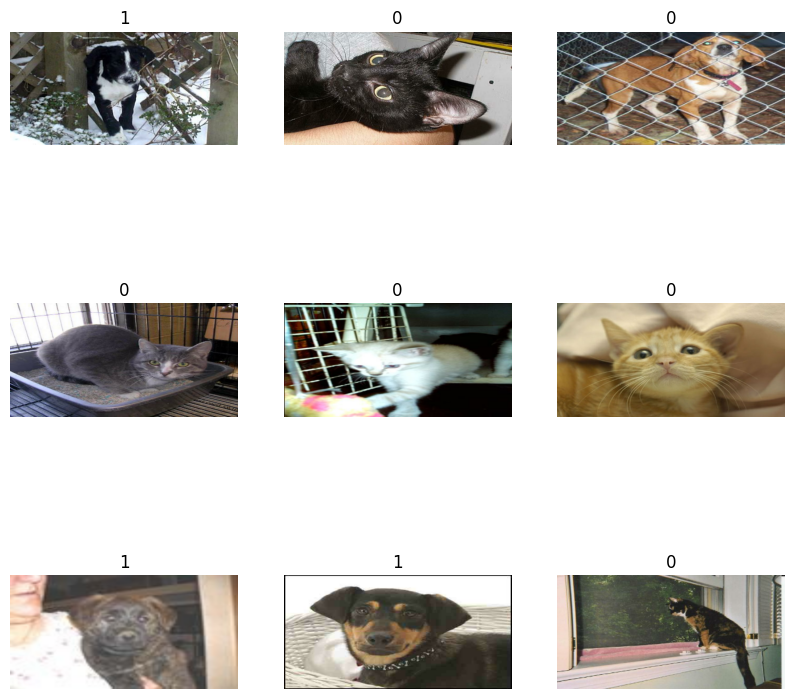

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

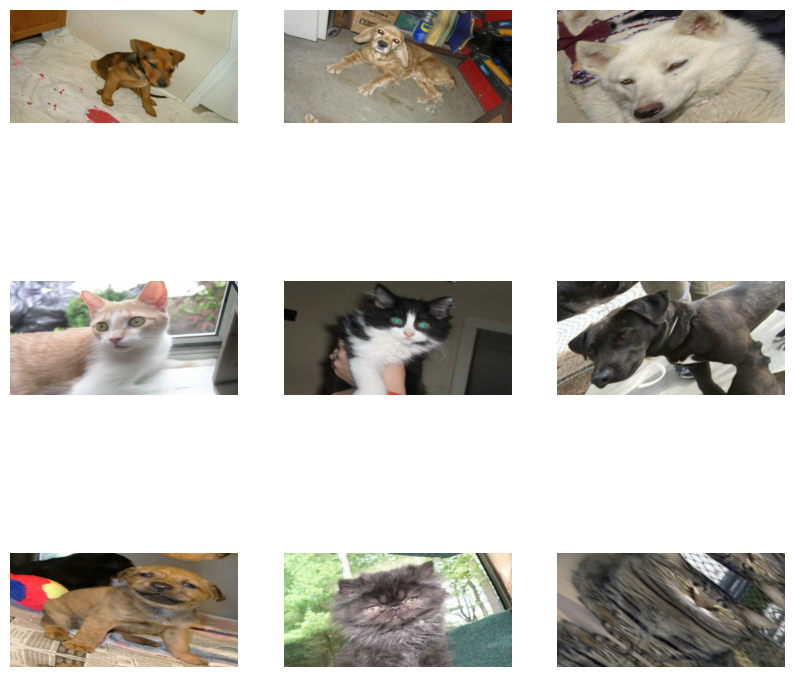

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
# выполним аугментации для обучающих данных предварительно (1 способ)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

In [7]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 100, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 50, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 25, 128)       0         
 g2D)                                                        

In [9]:
# компилируем сеть, указываем, что будем при обучении смотреть значения accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [10]:
# начинаем обучение
# указываем validation_data - при обучении будем получать accuracy для тестовой выборки
model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
51/51 [==============================] - 17s 324ms/step - loss: 0.8725 - accuracy: 0.4922 - val_loss: 0.6933 - val_accuracy: 0.4550
Epoch 2/5
51/51 [==============================] - 18s 342ms/step - loss: 0.6931 - accuracy: 0.5116 - val_loss: 0.6937 - val_accuracy: 0.4550
Epoch 3/5
51/51 [==============================] - 17s 322ms/step - loss: 0.6936 - accuracy: 0.5078 - val_loss: 0.6938 - val_accuracy: 0.4550
Epoch 4/5
51/51 [==============================] - 17s 326ms/step - loss: 0.6932 - accuracy: 0.5122 - val_loss: 0.6938 - val_accuracy: 0.4550
Epoch 5/5
51/51 [==============================] - 17s 322ms/step - loss: 0.6930 - accuracy: 0.5116 - val_loss: 0.6944 - val_accuracy: 0.4550


In [11]:
img = tf.keras.preprocessing.image.load_img(
    "../data/data3/cats/48.jpg", target_size=(200, 400)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predictions

1/1 [==============================] - 0s 61ms/step


array([[0.5063917, 0.4936083]], dtype=float32)

# Задание 2

## VGG19

In [12]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/data4", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 190 files belonging to 3 classes.
Using 162 files for training.
Using 28 files for validation.


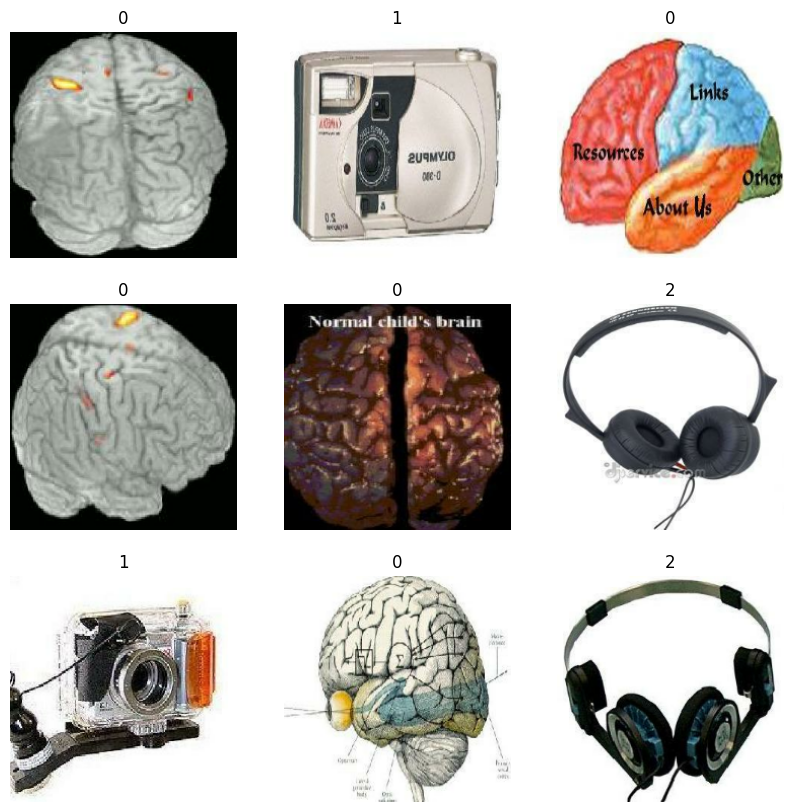

In [13]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [14]:
# загружаем предварительно обученную сеть VGG19
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [16]:
# посмотрим, что изменилось
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [17]:
# "заморозим" все слои, кроме последнего
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True

In [18]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [19]:
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
6/6 [==============================] - 13s 2s/step - loss: 0.4715 - accuracy: 0.8395 - val_loss: 0.0227 - val_accuracy: 1.0000
Epoch 2/5
6/6 [==============================] - 13s 2s/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 3/5
6/6 [==============================] - 12s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/5
6/6 [==============================] - 13s 2s/step - loss: 3.9462e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/5
6/6 [==============================] - 13s 2s/step - loss: 2.6179e-04 - accuracy: 1.0000 - val_loss: 9.2826e-04 - val_accuracy: 1.0000


In [20]:
img = tf.keras.preprocessing.image.load_img(
    "../data/data4/brain/image_0054.jpg", target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_new.predict(img_array)
predictions

1/1 [==============================] - 0s 186ms/step


array([[9.9997330e-01, 5.3866927e-07, 2.6130925e-05]], dtype=float32)

## InceptionV3

In [21]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/data4", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(299,299), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 190 files belonging to 3 classes.
Using 162 files for training.
Using 28 files for validation.


In [22]:
inc = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)

In [23]:
inc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [24]:
# сохраним ссылку на входной слой сети
inp = inc.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой и наш новый слой классификации
out = new_classification_layer(inc.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [25]:
# Заморозка слоев модели
for layer in inc.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True

In [26]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [27]:
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
6/6 [==============================] - 8s 1s/step - loss: 16.6396 - accuracy: 0.3272 - val_loss: 14.0005 - val_accuracy: 0.3929
Epoch 2/5
6/6 [==============================] - 5s 877ms/step - loss: 8.0427 - accuracy: 0.5370 - val_loss: 4.2470 - val_accuracy: 0.6071
Epoch 3/5
6/6 [==============================] - 5s 870ms/step - loss: 4.2656 - accuracy: 0.5679 - val_loss: 5.1989 - val_accuracy: 0.5714
Epoch 4/5
6/6 [==============================] - 5s 871ms/step - loss: 3.9699 - accuracy: 0.6481 - val_loss: 1.9965 - val_accuracy: 0.8571
Epoch 5/5
6/6 [==============================] - 5s 830ms/step - loss: 2.9227 - accuracy: 0.6543 - val_loss: 1.9827 - val_accuracy: 0.6429


In [28]:
img = tf.keras.preprocessing.image.load_img(
    "../data/data4/brain/image_0054.jpg", target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_new.predict(img_array)
predictions

1/1 [==============================] - 1s 658ms/step


array([[2.6422401e-04, 9.9973577e-01, 1.4143564e-08]], dtype=float32)